In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import callbacks

import zipfile
import shutil
import os


In [8]:
zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/aiffel/aiffel/DLthon/data/{}.zip".format(zip_file), "r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [10]:
train_dir = '/aiffel/aiffel/DLthon/train'
test_dir  = '/aiffel/aiffel/DLthon/test1'

train_file_list = os.listdir(train_dir)
test_file_list = os.listdir(test_dir)
print('No. of Train Images: {}'.format(len(train_file_list)))
print('No. of Test Images: {}'.format(len(test_file_list))) 

No. of Train Images: 25000
No. of Test Images: 12500


In [27]:
categories = []
for file in train_file_list:
    category = file.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')
        
df = pd.DataFrame({
    'filename': train_file_list,
    'category': categories
})
df.head()

,filename,category
0,cat.1214.jpg,cat
1,dog.2687.jpg,dog
2,cat.793.jpg,cat
3,cat.3978.jpg,cat
4,cat.6495.jpg,cat


<AxesSubplot:>

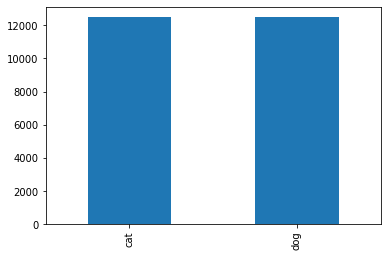

In [28]:
df['category'].value_counts().plot.bar()

In [29]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]

print(f'Number of Training images: {train_images}')
print(f'Number of Validation images: {valid_images}')

Number of Training images: 20000
Number of Validation images: 5000


<AxesSubplot:xlabel='category', ylabel='count'>

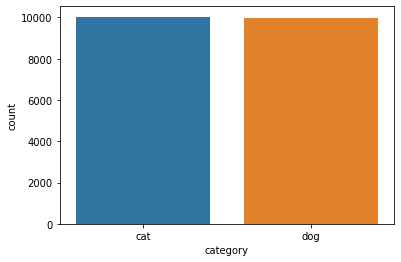

In [30]:
sns.countplot(x=train_df['category'])

<AxesSubplot:xlabel='category', ylabel='count'>

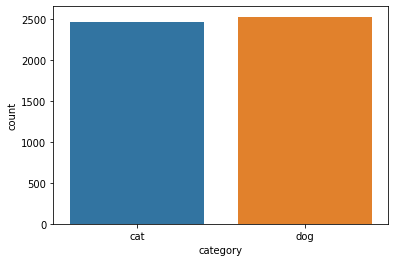

In [31]:
sns.countplot(x=valid_df['category'])

In [33]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_data_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_data_gen.flow_from_dataframe(train_df, train_dir,
                                               x_col = 'filename',
                                               y_col = 'category',
                                               target_size = (IMG_SIZE, IMG_SIZE),
                                               batch_size = BATCH_SIZE,
                                               class_mode = 'binary')

validation_data = train_data_gen.flow_from_dataframe(valid_df, train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## 모델 준비와 학습

In [34]:
callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=5,
                                         restore_best_weights=True),
                 callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            factor=0.2,
                                            min_lr=0.00001)]

In [36]:
resnet = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet.trainable = False
resnet_model = Sequential([resnet,
                         Flatten(),
                         Dense(512, activation = 'relu'),
                         Dropout(0.2),
                         Dense(1, activation = 'sigmoid')])

resnet_model.compile(optimizer='Adam',
                    loss='binary_crossentropy',
                    metrics = ['accuracy'])

resnet_model.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 74,946,049
Trainable params: 51,381,249
Non-trainable params: 23,564,800
_________________________________________________________________


In [38]:
resnet_history = resnet_model.fit(train_data,
                   epochs = 50,
                   validation_data = validation_data,
                    callbacks=callbacks_list)

Epoch 1/50
625/625 [==============================] - 123s 133ms/step - loss: 0.7192 - accuracy: 0.9741 - val_loss: 0.0741 - val_accuracy: 0.9820
Epoch 2/50
625/625 [==============================] - 81s 129ms/step - loss: 0.0343 - accuracy: 0.9905 - val_loss: 0.0761 - val_accuracy: 0.9832
Epoch 3/50
625/625 [==============================] - 81s 129ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0684 - val_accuracy: 0.9860
Epoch 4/50
625/625 [==============================] - 82s 132ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.0901 - val_accuracy: 0.9862
Epoch 5/50
625/625 [==============================] - 81s 130ms/step - loss: 0.0217 - accuracy: 0.9961 - val_loss: 0.1488 - val_accuracy: 0.9828
Epoch 6/50
625/625 [==============================] - 82s 131ms/step - loss: 0.0441 - accuracy: 0.9939 - val_loss: 0.1819 - val_accuracy: 0.9792
Epoch 7/50
625/625 [==============================] - 82s 131ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0842 - val_a

In [39]:
def plot_show(history):
    fig, ax = plt.subplots(2, 1, figsize= (10, 8))
    
    Epochs =range(len(history.history['loss']))
    
    sns.lineplot(x = Epochs, y = history.history['val_loss'], label='validation loss', ax=ax[0])
    sns.lineplot(x = Epochs, y = history.history['loss'], label = 'training loss', ax=ax[0])
    ax[0].set_title('loss')
    
    sns.lineplot(x = Epochs, y = history.history['val_accuracy'], label='validation accuracy', ax=ax[1])
    sns.lineplot(x = Epochs, y = history.history['accuracy'], label='training accuracy', ax=ax[1])
    ax[1].set_title('accuracy')
    
    plt.legend()
    plt.show()

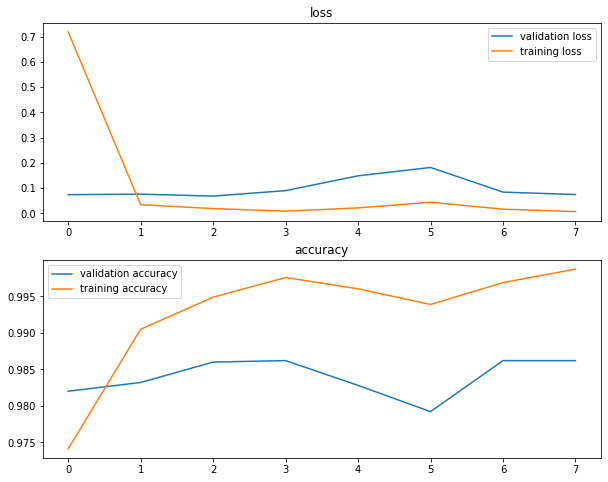

In [40]:
plot_show(resnet_history)

In [41]:
test_df = pd.DataFrame({'filename': test_file_list})

test_data_gen = ImageDataGenerator(rescale = 1./255)

test_data = test_data_gen.flow_from_dataframe(test_df, test_dir,
                                             x_col = 'filename',
                                             y_col = None,
                                             class_mode = None,
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             shuffle = False)


Found 12500 validated image filenames.


In [42]:
res_pred = resnet_model.predict(test_data)

In [46]:
submission_df = pd.read_csv("/aiffel/aiffel/DLthon/data/sampleSubmission.csv")
submission_df['pred'] = res_pred
submission_df.head(10)

,id,label,pred
0,1,0,6.980035e-08
1,2,0,0.000000e+00
2,3,0,9.999996e-01
3,4,0,9.999963e-01
4,5,0,9.999923e-01
5,6,0,2.527994e-14
6,7,0,2.245904e-31
7,8,0,1.525778e-11
8,9,0,8.629321e-24
9,10,0,0.000000e+00


In [48]:
submission_df['label'] = submission_df['pred'].apply(lambda x: 1 if x > 0.5 else 0)

submission_df.head(10)

,id,label,pred
0,1,0,6.980035e-08
1,2,0,0.000000e+00
2,3,1,9.999996e-01
3,4,1,9.999963e-01
4,5,1,9.999923e-01
5,6,0,2.527994e-14
6,7,0,2.245904e-31
7,8,0,1.525778e-11
8,9,0,8.629321e-24
9,10,0,0.000000e+00


In [50]:
submission_df = submission_df.drop('pred', axis=1)
submission_df.head(10)

,id,label
0,1,0
1,2,0
2,3,1
3,4,1
4,5,1
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [52]:
submission_df.to_csv('submission.csv', index=False)